<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/01_neural_network_regression_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Hồi quy mạng nơ-ron với TensorFlow

Có nhiều định nghĩa cho [bài toán hồi quy](https://en.wikipedia.org/wiki/Regression_analysis), nhưng trong trường hợp này, chúng ta sẽ đơn giản hóa nó: dự đoán một số.

Ví dụ, chúng ta có thể:
- Dự đoán giá bán nhà khi biết các thông tin nhất định (số lượng phòng, kích thước, số phòng tắm).
- Dự đoán tọa độ của bounding box (hình chữ nhật bao quanh đối tượng) của một phần tử trong hình.
- Dự đoán giá bảo hiểm cho cá nhân dựa trên nhân khẩu học (tuổi, giới tính, chủng tộc).

Trong notebook này, chúng ta sẽ đặt nền tảng cho cách lấy mẫu đầu vào (dữ liệu của bạn), xây dựng mạng nơ-ron để khám phá các mẫu (pattern) trong các đầu vào đó rồi đưa ra dự đoán (ở dạng số) dựa trên các đầu vào đó.

## Những điều chúng ta sẽ tìm hiểu

Chúng ta sẽ xem xét thực hiện những điều sau với TensorFlow:
- Kiến trúc của mô hình hồi quy
- Shape của đầu vào và đầu ra
  - `X`: đặc trưng/dữ liệu (đầu vào)
  - `y`: nhãn (đầu ra)
- Tạo dữ liệu tùy chỉnh để xem và điều chỉnh
- Các bước mô hình hóa
  - Tạo mô hình
  - Biên dịch mô hình
    - Định nghĩa hàm mất mát
    - Thiết lập optimizer
    - Tạo các phép đo đánh giá
  - Khớp mô hình (để tìm pattern trong dữ liệu)
- Đánh giá mô hình
  - Hiển thị mô hình ("visualize, visualize, visualize")
  - Xem xét đồ thị huấn luyện
  - So sánh các dự đoán với nhãn gốc (sử dụng các phép đo đánh giá)
- Save mô hình (để dùng sau)
- Load mô hình

Đừng lo lắng nếu chưa hiểu những điều này, chúng ta sẽ lần lượt đi qua từng thứ.

## Cách sử dụng notebook này

Các bạn có thể đọc qua các mô tả và code (tất cả sẽ chạy), nhưng có một lựa chọn tốt hơn.

Tự viết toàn bộ code.

Nghiêm túc đấy. Hãy tạo notebook mới và tự viết lại từng dòng. Kiểm tra xem bạn có thể thay đổi nó không và lý do cho điều đó.

Bạn không cần viết mô tả văn bản nhưng tự viết lại code là một cách tuyệt vời để có trải nghiệm thực tiễn.

Đừng lo lắng nếu mắc sai sót, ai cũng đều mắc lỗi cả. Cách thực hiện tốt hơn và mắc ít lỗi hơn là **viết nhiều code hơn**.

## Kiến trúc điển hình của mạng nơ-ron hồi quy

Từ *điển hình* ở đây được sử dụng có chủ đích.

Tại sao?

Vì có nhiều cách khác nhau (thực ra có vô số cách) để viết mạng nơ-ron.

Nhưng dưới đây là một thiết lập chung để nhập tập hợp các số, tìm các mẫu trong đó rồi xuất một vài loại số mục tiêu.

Câu trước còn mơ hồ nhưng chúng ta sẽ hiểu rõ hơn ngay sau đây.

| **Siêu tham số** | **Giá trị điển hình** |
| --- | --- |
| Shape của layer đầu vào | Có shape tương đương với số đặc trưng (ví dụ: 3 cho # bedrooms, # bathrooms, # car spaces trong dự đoán giá nhà) |
| (Các) layer ẩn | Bài toán cụ thể, min = 1, max = unlimited (không giới hạn) |
| Nơ-ron mỗi layer ẩn | Bài toán cụ thể,, thường từ 10 tới 100 |
| Shape của layer đầu ra | Có shape tương tự với shape của dự đoán mong muốn (ví dụ: 1 cho giá nhà) |
| Kích hoạt ẩn | Thường là [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Kích hoạt đầu ra | None, ReLU, logistic/tanh |
| Hàm mất mát | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) nếu có outlier |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

***Bảng 1:*** *Kiến trúc đặc trưng của mạng nơ-ron hồi quy.*  ***Nguồn:*** *trích từ [Aurélien Géron. "Hands-On Machine Learning with Scikit-Learn", Keras & TensorFlow, trang 293](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*

Nếu chưa quen với mạng nơ-ron và học sâu nói chung thì bạn sẽ không hiểu phần lớn bảng trên. Nhưng đừng lo, chúng ta sẽ sớm nắm rõ.

> 🔑 **Lưu ý:** **Hyperparameter (Siêu tham số)** trong ML là thứ mà nhà phân tích dữ liệu hay nhà phát triển có thể tự thiết lập, trong khi **parameter (tham số)** thường mô tả thứ mà mô hình tự tìm hiểu được (giá trị không được nhà phân tích thiết lập rõ ràng)

Hãy bắt đầu viết code thôi.

Chúng ta sẽ import alias thường gặp là `tf` (viết tắt của TensorFlow) để sử dụng TensorFlow.

In [ ]:
import tensorflow as tf
print(tf.__version__) # kiểm tra phiên bản (nên là 2.x+)

2.3.0


## Tạo dữ liệu để xem và điều chỉnh

Chúng ta đang làm việc với **bài toán hồi quy** (dự đoán một số) nên hãy tạo một vài dữ liệu tuyến tính (đường thẳng) cho mô hình.

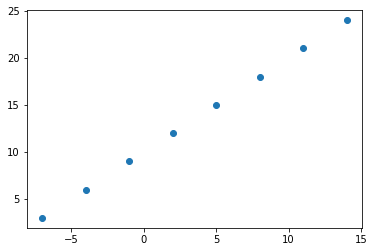

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo đặc trưng
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Tạo nhãn
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Hiển thị
plt.scatter(X, y);

Trước khi thực hiện mô hình hóa, chúng ta cần tính toán pattern giữa `X` và `y`.

Chẳng hạn: giả sử dựa trên dữ liệu này, giá trị `y` sẽ là bao nhiêu nếu `X` là 17.0?

Hoặc nếu `X` là -10.0?

Kiểu pattern này về bản chất là những gì chúng ta xây dựng mạng nơ-ron để thực hiện mọi việc.

## Shape của đầu vào và đầu ra trong hồi quy


Một trong những khái niệm quan trọng nhất khi làm việc với mạng nơ-ron là input / output shape.

**Input shape** là kích thước của dữ liệu đi vào mô hình.

**Output shape** là kích thước của dữ liệu xuất ra khỏi mô hình.

Chúng khác nhau tùy thuộc vào bài toán mà chúng ta đang xem xét.

Mạng nơ-ron chấp nhận các số và số đầu ra. Chúng thường được biểu diễn là tensor (hoặc mảng).

Trước đây chúng ta đã tạo dữ liệu với mảng Numpy, tuy nhiên chúng ta cũng có thể thực hiện tương tự với tensor.

In [ ]:
# Ví dụ về input / output shape của mô hình hồi quy
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])
house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [ ]:
house_info.shape

TensorShape([3])

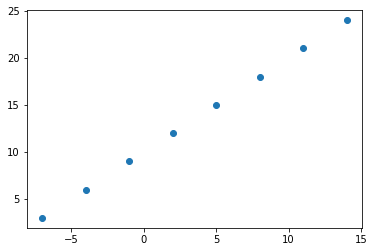

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo đặc trưng (sử dụng tensor)
X = tf.constant([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Tạo nhãn (sử dụng tensor)
y = tf.constant([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Hiển thị
plt.scatter(X, y);

Mục tiêu của chúng ta là dùng `X` để đoán `y`.

Như vậy **đầu vào** sẽ là `X` còn **đầu ra** sẽ là `y`.

Biết được điều này, bạn nghĩ shape của đầu vào/đầu ra sẽ là gì?

Hãy xem.

In [ ]:
# Lấy một ví dụ đơn lẻ của X
input_shape = X[0].shape

# Lấy một ví dụ đơn lẻ của y
output_shape = y[0].shape

input_shape, output_shape # chúng đều là số vô hướng (không có shape)

(TensorShape([]), TensorShape([]))

Có vẻ như đầu vào và đầu ra không có shape.

Tại sao?

Do dù chúng ta truyền bất kỳ dữ liệu nào vào mô hình thì nó cũng luôn lấy đầu vào và trả về đầu ra là một số kiểu tensor.

Nhưng trong trường hợp này, do tập dữ liệu (chỉ 2 danh sách nhỏ có các số) nên chúng ta sẽ xem xét các kiểu tensor đặc biệt, cụ thể là tensor bậc 0 hoặc một số vô hướng.

In [ ]:
# Hãy xem xét riêng từng ví dụ
X[0], y[0]

(<tf.Tensor: shape=(), dtype=float32, numpy=-7.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>)

Trong trường hợp này, chúng ta sẽ xây dựng mô hình để dự đoán patterm giữa `X[0]` = `-7.0` và `y[0]` = `3.0`.

Chúng ta đã có đáp án, hãy thử dùng 1 giá trị `X` để dự đoán 1 giá trị `y`.

Có thể các bạn đang nghĩ "điều này khá phức tạp khi chỉ dự đoán một đường thẳng..."

Bạn đúng đấy.

Nhưng những khái niệm mà chúng ta đang tìm hiểu ở đây, khái niệm về shape của đầu vào/đầu ra là những khái niệm cơ bản của một mô hình.

Thực tế, đây là hai trong số những điều mà chúng ta sẽ dành phần lớn thời gian khi làm việc với mạng nơ-ron: **đảm bảo đầu vào và đầu ra ở đúng shape**.

Nếu giờ bạn vẫn chưa rõ, hãy xem thêm nhiều ví dụ khác sau này (chúng ta sẽ thấy shape của đầu vào và đầu ra có thể là bất cứ thứ gì mà chúng ta nghĩ ra).

![example of input and output shapes for a housing price prediction problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/01-input-and-output-shapes-housing-prices.png)
*Nếu bạn đang xây dựng một thuật toán học máy để dự đoán giá nhà, đầu vào sẽ là số phòng ngủ, số phòng tắm và số ga-ra; cho đầu vào có shape là 3 (3 đặc trưng khác nhau). Và do bạn đang cố dự đoán giá nhà nên shape của đầu ra sẽ là 1.*

## Các bước mô hình hóa với TensorFlow

Bây giờ chúng ta biết chúng ta có dữ liệu gì cũng như các input/output shape, hãy xem cách xây dựng một mạng nơ-ron để mô hình hóa nó.

Trong TensorFlow, có 3 bước chính để tạo và huấn luyện một mô hình:

1. **Tạo mô hình** - tự ghép các layer của mô hình nơ-ron (sử dụng [Functional](https://www.tensorflow.org/guide/keras/functional) hoặc [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) hoặc import mô hình đã xây trước đó (học truyền tải).
2. **Biên dịch mô hình** - xác định cách đo chất lượng một mô hình (loss/phép đo) cũng như cách cải thiện nó (optimizer).
3. **Khớp mô hình** - hãy để mô hình thử tìm pattern trong dữ liệu (cách để `X` thành `y`).

Hãy xem cách triển khai những điều này với [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) để xây mô hình cho dữ liệu hồi quy.


In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình sử dụng Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Biên dịch mô hình
model.compile(loss=tf.keras.losses.mae, # mae là viết tắt của mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD là viết tắt của stochastic gradient descent
              metrics=["mae"])

# Khớp mô hình
model.fit(X, y, epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 1ms/step - loss: 11.5048 - mae: 11.5048
Epoch 2/5
1/1 [==============================] - 0s 1ms/step - loss: 11.3723 - mae: 11.3723
Epoch 3/5
1/1 [==============================] - 0s 887us/step - loss: 11.2398 - mae: 11.2398
Epoch 4/5
1/1 [==============================] - 0s 3ms/step - loss: 11.1073 - mae: 11.1073
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 10.9748 - mae: 10.9748


Chúng ta vừa huấn luyện một mô hình để tìm các pattern giữa `X` và `y`.

Bạn nghĩ nó diễn ra thế nào?

In [ ]:
# Kiểm tra X và y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

Các bạn nghĩ kết quả là gì nếu chúng ta truyền cho mô hình giá trị `X` bằng 17.0?

In [ ]:
# Dự đoán theo mô hình
model.predict([17.0])

array([[12.716021]], dtype=float32)

Có vẻ không ổn lắm...lẽ ra nó nên xuất ra kết quả gần 27.0.

> 🤔 **Câu hỏi:** Keras là gì? Tôi nghĩ chúng ta đang làm việc với TensorFlow nhưng mỗi lần viết code TensorFlow, `keras` đều xuất hiện sau `tf` (chẳng hạn: `tf.keras.layers.Dense()`).

Trước TensorFlow 2.0+, [Keras](https://keras.io/) là một API được thiết kế để dễ dàng xây dựng mô hình học sâu . Từ TensorFlow 2.0+, chức năng của nó được tích hợp trong thư viện TensorFlow.

## Cải thiện mô hình

Các bạn nghĩ sao về việc cải thiện mô hình hiện tại?

Nếu bạn đoán là bằng cách điều chỉnh một số thứ mà chúng ta đã thực hiện ở trên thì bạn đoán đúng rồi.

Để cải thiện mô hình, chúng ta sẽ thay đổi hầu hết mọi phần của 3 bước mà chúng ta đã xét trước đó.

1. **Tạo mô hình** - ở đây có thể chúng ta muốn thêm nhiều layer, tăng số đơn vị ẩn (hay còn gọi là nơ-ron) ở từng layer, thay đổi hàm kích hoạt của từng layer.
2. **Biên dịch mô hình** - chúng ta có thể chọn hàm tối ưu hoặc thay đổi **tốc độ học** của hàm tối ưu.
3. **Khớp mô hình** - chúng ta có thể khớp mô hình cho nhiều **epoch** hơn (để huấn luyện lâu hơn) hoặc trên nhiều dữ liệu hơn (cho mô hình các mẫu để học).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*Có nhiều cách khác nhau để cải thiện mạng nơ-ron. Một số cách phổ biến nhất gồm: tăng số layer (làm cho mạng sâu hơn), tăng số đơn vị ẩn (làm cho mạng rộng hơn) và thay đổi tốc độ học. Do các giá trị này đều có thể thay đổi nên chúng là các [hyperparameter (siêu tham số)](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) và việc cố gắng tìm ra siêu tham số tốt nhất được gọi là [điều chỉnh siêu tham số](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Chúng ta đã đề xuất rất nhiều bước khả thi. Cần nhớ rằng cách mà chúng ta thay đổi từng bước sẽ phụ thuộc vào bài toán mà chúng ta đang giải.

Chúng ta sẽ giải quyết chúng qua vài bài toán tiếp theo.

Bây giờ để đơn giản, chúng ta sẽ chỉ huấn luyện mô hình lâu hơn (mọi thứ vẫn giữ nguyên).

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình (như trên)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Biên dịch mô hình (như trên)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Khớp mô hình (lần này chúng ta sẽ huấn luyện lâu hơn)
model.fit(X, y, epochs=100) # huấn luyện cho 100 epoch, không phải 10

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 11.5048 - mae: 11.5048
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 11.3723 - mae: 11.3723
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 11.2398 - mae: 11.2398
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 11.1073 - mae: 11.1073
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 10.9748 - mae: 10.9748
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 10.8423 - mae: 10.8423
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 10.7098 - mae: 10.7098
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 10.5773 - mae: 10.5773
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 10.4448 - mae: 10.4448
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 10.3123 - mae: 10.3123
Epoch 11/100
1/1 [==============================] - 0s 2ms/

Chúng ta nhận ra rằng giá trị loss giảm từ trước (và tiếp tục giảm khi số epoch tăng).

Các bạn nghĩ điều này có nghĩa gì khi chúng ta đưa ra dự đoán với mô hình?

Sao không thử dự đoán trên 17.0 một lần nữa?

In [ ]:
# Nhắc lại X và y là gì
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [ ]:
# Thử đoán y là gì nếu X bằng 17.0
model.predict([17.0]) # đáp án đúng là 27.0 (y = X + 10)

array([[30.158512]], dtype=float32)

Tốt hơn rồi!

Lần này chúng ta đã đoán gần đúng. Nhưng cần cải thiện hơn.

Chúng ta đã huấn luyện mô hình rồi, đánh giá nó thế nào?

## Đánh giá mô hình

Quy trình điển hình mà chúng ta sẽ xem xét khi xây dựng mạng nơ-ron như sau:

```
Xây dựng một mô hình -> đánh giá mô hình -> xây dựng (cải tiến) mô hình -> đánh giá mô hình -> xây dựng (cải tiến) mô hình -> đánh giá mô hình...
```

Việc cải tiến có thể không đến từ việc xây dựng mô hình từ đầu mà là điều chỉnh một mô hình có sẵn.

### Trực quan hóa

Khi tới bước đánh giá, hãy nhớ tới từ "visualize, visualize, visualize" (trực quan hóa).

Tức là các bạn nên quan sát (việc thực hiện) điều gì đó hơn là chỉ suy nghĩ.

Hãy trực quan hóa:
* **Dữ liệu** - chúng ta đang làm việc với dữ liệu nào? Nó trông thế nào?
* **Chính mô hình** - Kiến trúc trông như thế nào? Các hình dạng khác nhau là gì?
* **Huấn luyện của mô hình** - Mô hình thực hiện thế nào trong khi nó đang học?
* **Dự đoán của mô hình** -  Làm thế nào để các dự đoán khớp với nhãn gốc (nhãn ban đầu)?

Hãy bắt đầu trực quan hóa mô hình.

Nhưng trước tiên, hãy tạo tập dữ liệu lớn hơn một chút và một mô hình mới mà chúng ta có thể sử dụng (giống như trước, nhưng càng thực hành nhiều càng tốt).


In [ ]:
# Tạo tập dữ liệu lớn hơn
X = np.arange(-100, 100, 4)
X

array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96])

In [ ]:
# Tạo các nhãn cho tập dữ liệu (bám theo pattern trước đây)
y = np.arange(-90, 110, 4)
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

Vì $y=X+10$, chúng ta có thể tạo các nhãn như sau:

In [ ]:
# Cùng kết quả như trên
y = X + 10
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

## Chia dữ liệu thành tập huấn luyện/kiểm tra

Một trong những bước phổ biến và quan trọng khác trong dự án học máy là tạo tập huấn luyện và kiểm tra (và tập kiểm định khi cần).

Mỗi tập hợp lại phục vụ một mục đích cụ thể:
* **Tập huấn luyện** - mô hình học từ dữ liệu này, thường chiếm 70-80% tổng số dữ liệu sẵn có (giống như tư liệu khóa học trong một học kỳ).
* **Tập kiểm định** - mô hình được điều chỉnh dựa trên dữ liệu này, thường chiếm 10-15% tổng số dữ liệu sẵn có (giống như bài kiểm tra thực hành được thực hiện trước kỳ kiểm tra cuối môn).
* **Tập kiểm tra** - mô hình được đánh giá dựa trên dữ liệu này để kiểm tra những gì nó đã học, thường chiếm 10-15% tổng số dữ liệu sẵn có (giống như bài kiểm tra cuối môn mà bạn thực hiện vào cuối học kỳ).

Bây giờ, chúng ta sẽ chỉ sử dụng tập huấn luyện và tập kiểm tra, điều này có nghĩa là mô hình sẽ có một tập dữ liệu để học hỏi và đánh giá.

Hãy tạo chúng bằng cách chia các mảng `X` và `y`.

> 🔑 **Lưu ý:** Khi xử lý dữ liệu thực tế, bước này thường được thực hiện ngay khi bắt đầu dự án (tập kiểm tra phải luôn được giữ tách biệt với tất cả các dữ liệu khác). Chúng ta muốn mô hình của mình học trên dữ liệu huấn luyện rồi đánh giá nó trên dữ liệu kiểm tra để biết mức độ **khái quát hóa** của nó đối với các ví dụ chưa từng thấy.

In [ ]:
# Kiểm tra xem chúng ta có bao nhiêu mẫu
len(X)

50

In [ ]:
# Chia dữ liệu thành các tập huấn luyện và tập kiểm tra
X_train = X[:40] # 40 mẫu đầu tiên (40% dữ liệu)
y_train = y[:40]

X_test = X[40:] # 10 mẫu cuối (20% dữ liệu)
y_test = y[40:]

len(X_train), len(X_test)

(40, 10)

## Trực quan hóa dữ liệu

Bây giờ chúng ta đã có dữ liệu huấn luyện và kiểm tra, hãy trực quan hóa nó.

Hãy vẽ nó bằng một số màu đẹp để phân biệt mọi thứ với nhau.

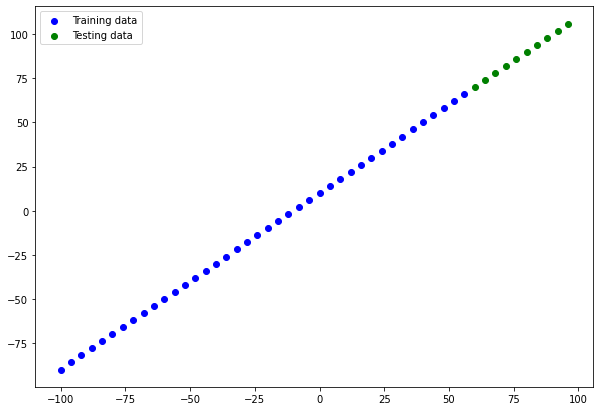

In [ ]:
plt.figure(figsize=(10, 7))
# Vẽ dữ liệu huấn luyện bằng màu xanh dương
plt.scatter(X_train, y_train, c='b', label='Training data')
# Vẽ dữ liệu kiểm tra bằng màu xanh lá
plt.scatter(X_test, y_test, c='g', label='Testing data')
# Hiển thị chú giải
plt.legend();

Tuyệt! Bất cứ lúc nào chúng ta cũng nên hiển thị dữ liệu, mô hình hay bất cứ thứ gì.

Với biểu đồ này, chúng ta sẽ cố gắng xây dựng một mô hình học pattern ở các chấm màu xanh dương (`X_train`) để vẽ các chấm màu xanh lá (`X_test`).

Đã đến lúc xây dựng mô hình. Chúng ta sẽ tạo mô hình giống hệt mô hình trước đó (mô hình mà chúng ta đã huấn luyện lâu hơn).

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình (như trên)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Biên dịch mô hình (như trên)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Khớp mô hình (tương tự như trên)
#model.fit(X_train, y_train, epochs=100) # ghi chú có chủ đích (chưa khớp với nó)

## Trực quan hóa mô hình

Sau khi xây xong mô hình, chúng ta cần quan sát nó (đặc biệt là nếu trước đây bạn chưa từng xây nhiều mô hình).

Hãy xem các layer và shape của mô hình bằng cách gọi [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary).

> 🔑 **Lưu ý:** Việc hiển thị mô hình vô cùng hữu ích khi chúng ta gặp sự cố không khớp shape đầu vào/đầu ra.

In [ ]:
# Không hoạt động (mô hình không khớp/không được xây)
model.summary()

ValueError: ignored

Cell ở trên bị lỗi vì chúng ta không khớp mô hình đã xây dựng.

Chúng ta cũng chưa cho nó biết shape đầu vào mà nó sẽ dự kiến.

Các bạn còn nhớ ở trên, chúng ta đã bàn rằng shape đầu vào chỉ là một số thế nào không?

Chúng ta có thể cho mô hình biết shape đầu vào của dữ liệu bằng cách sử dụng tham số `input_shape` cho layer đầu tiên (thường nếu `input_shape` không xác định, Keras sẽ cố gắng tự động tìm ra nó).

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình (như trên)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[1]) # định nghĩa input_shape cho mô hình
])

# Biên dịch mô hình (như trên)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

In [ ]:
# Điều này sẽ hoạt động sau khi chỉ định shape đầu vào
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Việc gọi `summary()` trên mô hình cho chúng ta thấy các layer mà nó chứa, shape đầu ra và số lượng tham số.
* **Total params** - tổng số tham số trong mô hình.
* **Trainable parameters** - đây là các tham số (pattern) mà mô hình có thể cập nhật khi nó huấn luyện.
* **Non-trainable parameters** - các tham số này không được cập nhật trong quá trình huấn luyện (điều này thường xảy ra khi chúng ta lấy các pattern đã học được từ các mô hình khác trong suốt quá trình transfer learning).

> 📖 **Tài liệu:** Để tìm hiểu sâu hơn về các tham số có thể huấn luyện trong một layer, hãy xem [video giới thiệu về deep learning của MIT](https://youtu.be/njKP3FqW3Sk).

> 🛠 **Luyện tập:** Thử nghiệm với số lượng đơn vị ẩn trong `Dense` layer (ví dụ: `Dense(2)`, `Dense(3)`). Điều này thay đổi Total/Trainable params như thế nào? Kiểm tra xem điều gì gây ra thay đổi.

Còn giờ, chúng ta cần nghĩ các tham số này là các pattern có thể học được trong dữ liệu.

Hãy khớp mô hình với dữ liệu huấn luyện.

In [ ]:
# Khớp mô hình với dữ liệu huấn luyện
model.fit(X_train, y_train, epochs=100, verbose=0) # verbose kiểm soát số lượng đầu ra thu được

In [ ]:
# Kiểm tra model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Cùng với summary, chúng ta cũng có thể xem biểu đồ 2D của mô hình bằng [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

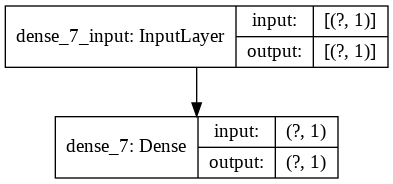

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

Trong trường hợp này, mô hình mà chúng ta đã dùng chỉ có đầu vào và đầu ra, nhưng việc hình dung các mô hình phức tạp hơn sẽ rất hữu ích cho việc gỡ lỗi.

## Hiển thị dự đoán

Chúng ta đã huấn luyện mô hình, hãy hiển thị một số dự đoán.

Để hiển thị các dự đoán, hãy vẽ chúng dựa trên nhãn gốc.

Chúng ta thường sẽ thấy điều này ở dạng `y_test` với `y_pred` (nhãn gốc với dự đoán).

Đầu tiên, chúng ta sẽ đưa ra một số dự đoán về dữ liệu kiểm tra (`X_test`), hãy nhớ rằng mô hình chưa bao giờ thấy dữ liệu kiểm tra.

In [ ]:
# Đưa ra dự đoán
y_preds = model.predict(X_test)

In [ ]:
# Quan sát các dự đoán
y_preds

array([[53.57109 ],
       [57.05633 ],
       [60.541573],
       [64.02681 ],
       [67.512054],
       [70.99729 ],
       [74.48254 ],
       [77.96777 ],
       [81.45301 ],
       [84.938255]], dtype=float32)

Chúng ta có một danh sách các số nhưng làm thế nào để so sánh chúng với nhãn đúng?

Hãy tạo một hàm vẽ biểu đồ để tìm hiểu.

> 🔑 **Lưu ý:** Nếu bạn nghĩ sẽ hiển thị nhiều, hãy hàm hóa nó để chúng ta có thể sử dụng sau này.

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=y_preds):
  """
  Vẽ dữ liệu huấn luyện, dữ liệu kiểm tra và so sánh các dự đoán.
  """
  plt.figure(figsize=(10, 7))
  # Vẽ dữ liệu huấn luyện bằng màu xanh dương
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Vẽ dữ liệu kiểm tra bằng màu xanh lá
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Vẽ các dự đoán bằng màu đỏ (những dự đoán được đưa ra trên dữ liệu kiểm tra)
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Hiển thị chú giải
  plt.legend();

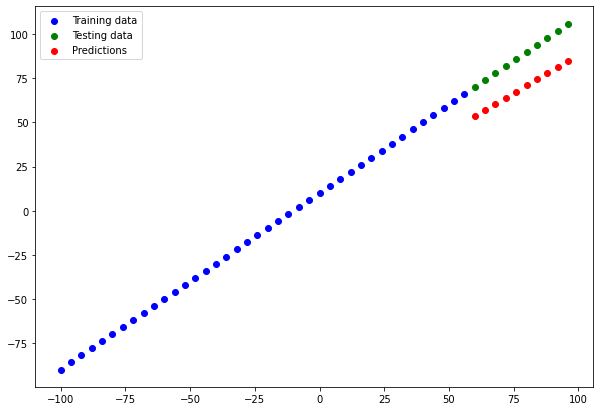

In [ ]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

Từ biểu đồ, chúng ta thấy các dự đoán không hoàn toàn kỳ lạ nhưng chúng chắc chắn cũng không có gì đặc biệt.

## Đánh giá dự đoán

Cùng với trực quan hóa, các phép đo đánh giá là lựa chọn thay thế tốt nhất để đánh giá mô hình.

Các mô hình khác nhau có các phép đo đánh giá khác nhau tùy thuộc vào bài toán mà chúng ta đang xử lý.

Hai trong số các phép đo chính được sử dụng cho bài toán hồi quy là:
* **Mean absolute error (MAE)** - sai số trung bình giữa mỗi dự đoán.
* **Mean squared error (MSE)** - sai số trung bình bình phương giữa các dự đoán (sử dụng nếu sai số lớn hơn bất lợi hơn so với sai số nhỏ hơn).

Mỗi giá trị này càng thấp thì càng tốt.

Chúng ta cũng có thể sử dụng [`model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) để trả về loss của mô hình cũng như bất kỳ thiết lập số liệu nào trong bước biên dịch.

In [ ]:
# Đánh giá mô hình trên dữ liệu kiểm tra
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 18.7453 - mae: 18.7453


[18.74532699584961, 18.74532699584961]

Trong trường hợp này, do chúng ta sử dụng MAE cho hàm mất mát cũng như MAE cho metrics nên `model.evaulate()` trả về cả hai.

TensorFlow cũng có hàm tích hợp sẵn cho MSE và MAE.

Tiền đề là giống nhau với nhiều hàm đánh giá: so sánh các dự đoán với nhãn gốc.

In [ ]:
# Tính mae
mae = tf.metrics.mean_absolute_error(y_true=y_test,
                                     y_pred=y_preds)
mae

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([34.42891 , 30.943668, 27.45843 , 23.97319 , 20.487946, 17.202168,
       14.510478, 12.419336, 11.018796, 10.212349], dtype=float32)>

Thật kỳ lạ, MAE đáng lẽ phải là đầu ra duy nhất.

Vậy mà chúng ta thu được 10 giá trị.

Điều này là do các tensor `y_test` và `y_preds` có shape khác nhau.

In [ ]:
# Kiểm tra các giá trị test label tensor
y_test

array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

In [ ]:
# Kiểm tra các giá trị predictions tensor (chú ý thêm dấu ngoặc vuông)
y_preds

array([[53.57109 ],
       [57.05633 ],
       [60.541573],
       [64.02681 ],
       [67.512054],
       [70.99729 ],
       [74.48254 ],
       [77.96777 ],
       [81.45301 ],
       [84.938255]], dtype=float32)

In [ ]:
# Kiểm tra shape của tensor
y_test.shape, y_preds.shape

((10,), (10, 1))

Một trong những vấn đề phổ biến nhất mà chúng ta sẽ gặp phải là làm thế nào để xử lý các shape đầu vào và đầu ra khác nhau, đây cũng là vấn đề mà lần này chúng ta phải đối mặt.

Nhưng đừng lo.

Chúng ta có thể khắc phục bằng cách sử dụng [`squeeze()`](https://www.tensorflow.org/api_docs/python/tf/squeeze), nó sẽ loại bỏ dimension `1` khỏi tensor `y_preds`, khiến nó có shape tương tự `y_test`.

> 🔑 **Lưu ý:** Nếu so sánh hai tensor thì cần đảm bảo chúng có shape phù hợp (chúng ta không phải lúc nào cũng thao tác với các shape, nhưng hãy lưu ý rằng khi các tensor không khớp, đặc biệt là shape đầu vào và đầu ra không khớp, sẽ gây ra *nhiều* lỗi).

In [ ]:
# Shape trước squeeze()
y_preds.shape

(10, 1)

In [ ]:
# Shape sau squeeze()
y_preds.squeeze().shape

(10,)

In [ ]:
# Chúng trông như thế nào?
y_test, y_preds.squeeze()

(array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106]),
 array([53.57109 , 57.05633 , 60.541573, 64.02681 , 67.512054, 70.99729 ,
        74.48254 , 77.96777 , 81.45301 , 84.938255], dtype=float32))

Chúng ta đã biết cách làm cho các tensor `y_test` và `y_preds` có cùng shape, hãy sử dụng các phép đo đánh giá.

In [ ]:
# Tính MAE
mae = tf.metrics.mean_absolute_error(y_true=y_test,
                                     y_pred=y_preds.squeeze()) # use squeeze() to make same shape
mae

<tf.Tensor: shape=(), dtype=float32, numpy=18.745327>

In [ ]:
# Tính MSE
mse = tf.metrics.mean_squared_error(y_true=y_test,
                                    y_pred=y_preds.squeeze())
mse

<tf.Tensor: shape=(), dtype=float32, numpy=353.57336>

Chúng ta cũng có thể tính toán MAE bằng cách sử dụng các hàm TensorFlow thuần túy.

In [ ]:
# Trả về kết quả tương tự tf.metrics.mean_absolute_error()
tf.reduce_mean(tf.abs(y_test-y_preds.squeeze()))

<tf.Tensor: shape=(), dtype=float64, numpy=18.745327377319335>

Chúng ta nên hàm hóa lại bất cứ thứ gì có thể sử dụng lại (hoặc tìm những thử có thể sử dụng đi sử dụng lại nhiều lần).

Hãy tạo hàm cho các phép đo đánh giá của chúng ta.

In [ ]:
def mae(y_test, y_pred):
  """
  Tính MAE giữa y_test và y_preds.
  """
  return tf.metrics.mean_absolute_error(y_test,
                                        y_pred)

def mse(y_test, y_pred):
  """
  Tính MSE giữa y_test và y_preds.
  """
  return tf.metrics.mean_squared_error(y_test,
                                       y_pred)

## Chạy thử nghiệm để cải thiện mô hình

Sau khi xem các phép đo đánh giá và dự đoán mà mô hình đưa ra, có thể chúng ta sẽ cần cải thiện nó.

Có nhiều cách thực hiện khác nhau, trong đó có 3 cách chính là:
1. **Lấy nhiều dữ liệu hơn** - lấy thêm mẫu để mô hình huấn luyện (có thêm nhiều cơ hội để học các pattern).
2. **Khiến mô hình lớn hơn (sử dụng mô hình phức tạp hơn)** - điều này có thể ở dạng nhiều layer hơn hoặc nhiều đơn vị ẩn hơn ở mỗi layer.
3. **Huấn luyện lâu hơn** - tăng khả năng mô hình tìm thấy pattern trong dữ liệu.

Do chúng ta đã tạo ra tập dữ liệu nên chúng ta có thể dễ dàng tạo thêm dữ liệu, tuy nhiên điều này không phải lúc nào cũng xảy ra khi chúng ta làm việc với tập dữ liệu thực tế.

Hãy xem làm thế nào để cải thiện mô hình bằng cách sử dụng 2 và 3.

Để thực hiện, chúng ta sẽ xây dựng 3 mô hình và so sánh kết quả của chúng:
1. `model_1` - tương tự mô hình ban đầu, 1 layer, huấn luyện cho 100 epoch.
2. `model_2` - 2 layer, huấn luyện cho 100 epoch.
3. `model_3` - 2 layer, huấn luyện cho 500 epoch.

**Xây dựng `model_1`**

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Sao chép mô hình ban đầu
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Biên dịch mô hình
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Khớp mô hình
model_1.fit(X_train, y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 15.9024 - mae: 15.9024
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 11.2837 - mae: 11.2837
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 11.1074 - mae: 11.1074
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 9.2991 - mae: 9.2991
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 10.1677 - mae: 10.1677
Epoch 6/100
2/2 [==============================] - 0s 1ms/step - loss: 9.4303 - mae: 9.4303
Epoch 7/100
2/2 [==============================] - 0s 1ms/step - loss: 8.5704 - mae: 8.5704
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 9.0442 - mae: 9.0442
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 18.7517 - mae: 18.7517
Epoch 10/100
2/2 [==============================] - 0s 1ms/step - loss: 10.1142 - mae: 10.1142
Epoch 11/100
2/2 [==============================] - 0s 2ms/step - l

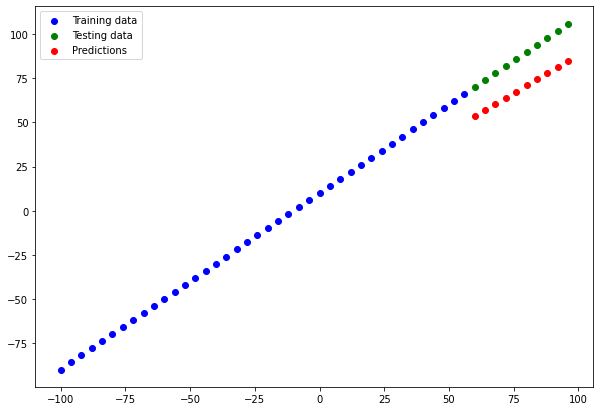

In [ ]:
# Đưa ra và vẽ biểu đồ dự đoán cho model_1
y_preds_1 = model_1.predict(X_test)
plot_predictions(predictions=y_preds_1)

In [ ]:
# Tính các phép đo model_1
mae_1 = mae(y_test, y_preds_1.squeeze()).numpy()
mse_1 = mse(y_test, y_preds_1.squeeze()).numpy()
mae_1, mse_1

(18.745327, 353.57336)

**Xây dựng `model_2`**

Lần này chúng ta sẽ thêm một dense layer (như vậy chúng ta sẽ có 2 layer) còn những thứ khác vẫn giữ nguyên.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Sao chép model_1 và thêm một layer bổ sung
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1) # thêm layer thứ hai
])

# Biên dịch mô hình
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Khớp mô hình
model_2.fit(X_train, y_train, epochs=100, verbose=0) # đặt verbose bằng 0 cho ít đầu ra hơn

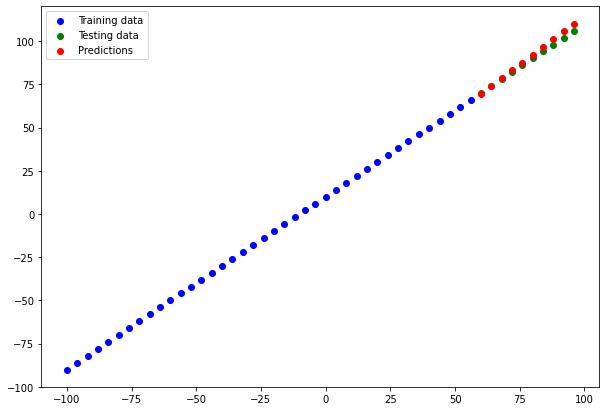

In [ ]:
# Đưa ra và vẽ biểu đồ dự đoán cho model_2
y_preds_2 = model_2.predict(X_test)
plot_predictions(predictions=y_preds_2)

Trông tốt hơn rồi đấy! Tất cả những gì nó cần là thêm một lớp.

In [ ]:
# Tính các phép đo model_2
mae_2 = mae(y_test, y_preds_2.squeeze()).numpy()
mse_2 = mse(y_test, y_preds_2.squeeze()).numpy()
mae_2, mse_2

(1.9098114, 5.459232)

**Xây dựng `model_3`**

Với mô hình thứ 3, chúng ta sẽ giữ nguyên mọi thứ như `model_2`, trừ việc lần này chúng ta sẽ huấn luyện lâu hơn (500 epoch chứ không phải 100).

Điều này sẽ giúp mô hình có nhiều cơ hội hơn để tìm hiểu các pattern trong dữ liệu.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Sao chép model_2
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Biên dịch mô hình
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Khớp mô hình (lần này là cho 500 epoch, không phải 100)
model_3.fit(X_train, y_train, epochs=500, verbose=0) # đặt verbose bằng 0 cho ít đầu ra hơn

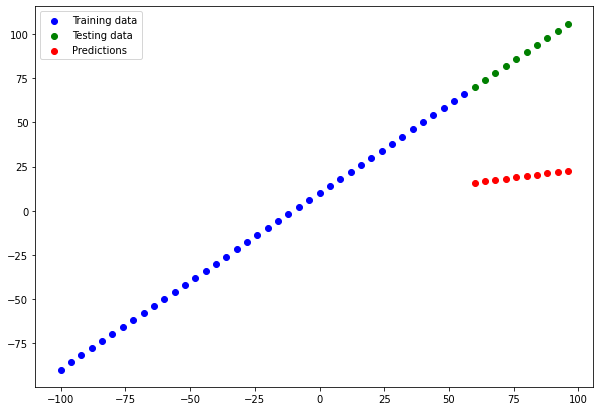

In [ ]:
# Đưa ra và vẽ biểu đồ dự đoán cho  model_3
y_preds_3 = model_3.predict(X_test)
plot_predictions(predictions=y_preds_3)

Thật kỳ lạ, chúng ta đã huấn luyện lâu hơn nhưng mô hình lại hoạt động kém hơn.

Hóa ra mô hình có thể đã huấn luyện quá lâu, do đó dẫn đến kết quả tồi tệ hơn (chúng ta sẽ tìm hiểu các cách ngăn chặn việc huấn luyện quá lâu sau).

In [ ]:
# Tính các phép đo model_3
mae_3 = mae(y_test, y_preds_3.squeeze()).numpy()
mse_3 = mse(y_test, y_preds_3.squeeze()).numpy()
mae_3, mse_3

(68.68786, 4804.4717)

## So sánh kết quả

Chúng ta thu được 3 kết quả tương tự, chỉ hơi khác nhau một chút, hãy so sánh chúng.

In [ ]:
model_results = [["model_1", mae_1, mse_1],
                 ["model_2", mae_2, mse_2],
                 ["model_3", mae_3, mae_3]]

In [ ]:
import pandas as pd
all_results = pd.DataFrame(model_results, columns=["model", "mae", "mse"])
all_results

,model,mae,mse
0,model_1,18.745327,353.573364
1,model_2,1.909811,5.459232
2,model_3,68.687859,68.687859


Từ các thử nghiệm, có vẻ `model_2` hoạt động tốt nhất.

Và giờ, bạn có thể nghĩ, "việc so sánh các mô hình thật tẻ nhạt ..." và chắc chắn là vậy, chúng ta chỉ so sánh 3 mô hình ở đây.

Nhưng đây là một phần của mô hình học máy: thử nhiều tổ hợp mô hình khác nhau và xem mô hình nào hoạt động tốt nhất.

Mỗi mô hình mà chúng ta xây dựng là một thử nghiệm nhỏ.

> 🔑 **Lưu ý:** Một trong những mục tiêu chính của chúng ta là giảm thiểu thời gian giữa các thử nghiệm. Càng thử nghiệm nhiều thì chúng ta sẽ càng biết điều gì hiệu quả và không hiệu quả. Hãy nhớ phương châm khi học machine learning: "thử nghiệm, thử nghiệm, thử nghiệm".

Các bạn cũng sẽ thấy là những gì bạn nghĩ có thể hoạt động (chẳng hạn như huấn luyện mô hình lâu hơn) không phải lúc nào cũng hiệu quả và điều ngược lại cũng thường xảy ra.

## Theo dõi các thử nghiệm

Chúng ta cần rèn thói quen theo dõi các thử nghiệm lập mô hình để xem thử nghiệm nào hoạt động tốt hơn so với những thử nghiệm khác.

Chúng ta đã thực hiện một phiên bản đơn giản của điều này ở trên (giữ nguyên kết quả ở các biến khác nhau).

> 📖 **Tài liệu:** Nhưng khi xây dựng nhiều mô hình hơn, chúng ta sẽ cần xem xét sử dụng các công cụ như:
* [**TensorBoard**](https://tensorboard.dev/) - thành phần của thư viện TensorFlow, giúp theo dõi các thử nghiệm lập mô hình (sẽ tìm hiểu sau).
* [**Weights & Biases**](https://www.wandb.com/) - công cụ theo dõi tất cả các loại thử nghiệm học máy (tin tốt là Weights & Biases đã được đưa vào TensorBoard).

## Lưu mô hình

Sau khi đã huấn luyện mô hình và tìm ra mô hình hoạt động như mong muốn, có thể bạn sẽ muốn lưu nó để sử dụng ở nơi khác (như ứng dụng web hoặc thiết bị di động).

Chúng ta có thể lưu mô hình TensorFlow/Keras bằng [`model.save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model).

Có hai cách để lưu một mô hình trong TensorFlow:
1. [SavedModel format](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) (mặc định).
2. [HDF5 format](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format).

Khác biệt chính giữa hai cách này là SavedModel có thể tự động lưu các đối tượng tùy chỉnh (chẳng hạn như các layer đặc biệt) mà không cần sửa đổi thêm khi load mô hình trở lại.

Chúng ta nên sử dụng cái nào?

Điều này tùy thuộc vào tình huống của bạn nhưng hầu như SavedModel format sẽ đáp ứng.

Cả hai phương pháp đều sử dụng cùng một phép gọi phương thức.

In [ ]:
# Lưu mô hình với SavedModel format
model_2.save('best_model_SavedModel_format')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model_SavedModel_format/assets


In [ ]:
# Hãy kiểm tra - xuất ra file nhị phân protobuf (.pb) cũng như các file khác
!ls best_model_SavedModel_format

assets	saved_model.pb	variables


Bây giờ hãy lưu mô hình ở định dạng HDF5, chúng ta sẽ sử dụng cùng một phương pháp nhưng với tên file khác.

In [ ]:
# Lưu mô hình với HDF5 format
model_2.save("best_model_HDF5_format.h5") # lưu ý '.h5' ở cuối

In [ ]:
# Hãy kiểm tra
!ls best_model_HDF5_format.h5

best_model_HDF5_format.h5


## Load mô hình

Chúng ta có thể load một mô hình đã lưu bằng phương thức [`load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model).

Việc load mô hình cho các định dạng khác nhau (SavedModel và HDF5) là giống nhau (miễn là tên đường dẫn đến các định dạng cụ thể là chính xác).

In [ ]:
# Load mô hình từ SavedModel format
loaded_saved_model = tf.keras.models.load_model("best_model_SavedModel_format")
loaded_saved_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Hãy kiểm tra.

In [ ]:
# So sánh model_2 với phiên bản SavedModel (nên trả về True)
model_2_preds = model_2.predict(X_test)
saved_model_preds = loaded_saved_model.predict(X_test)
mae(y_test, saved_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

True

Load từ HDF5 cũng khá tương tự.

In [ ]:
# Load mô hình từ HDF5 format
loaded_h5_model = tf.keras.models.load_model("best_model_HDF5_format.h5")
loaded_h5_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# So sánh model_2 với phiên bản HDF5 đã load (nên trả về True)
h5_model_preds = loaded_h5_model.predict(X_test)
mae(y_test, h5_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

True

## Download mô hình (từ Google Colab)

Giả sử bạn muốn đưa mô hình của mình từ Google Colab vào loacal machine, có thể thực hiện một trong những điều sau:
* Nhấp chuột phải vào file trong file panel và click vào 'download'.
* Sử dụng code bên dưới.

In [ ]:
# Download mô hình (hoặc file bất kỳ) từ Google Colab
from google.colab import files
files.download("best_model_HDF5_format.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ví dụ lớn hơn

Chúng ta đã thấy các yếu tố cơ bản khi xây dựng mô hình hồi quy mạng nơ-ron trong TensorFlow.

Hãy nâng nó lên một tầm cao mới và xây dựng mô hình cho cơ sở dữ liệu có nhiều đặc trưng hơn.

Cụ thể hơn, chúng ta sẽ thử dự đoán chi phí bảo hiểm y tế cho các cá nhân dựa trên một số tham số khác nhau như: `age`, `sex`, `bmi`, `children`, `smoking_status` và `residential_region`.

Để thực hiện, chúng ta sẽ tận dụng [tập dữ liệu Medical Cost](https://www.kaggle.com/mirichoi0218/insurance) sẵn có từ Kaggle và [được lưu trữ trên GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).

> 🔑 **Lưu ý:** Khi tìm hiểu các mô hình học máy, chúng ta thường sẽ trải qua một loạt các kỹ thuật nền tảng rồi thực hành bằng cách làm việc với các mẫu và tập dữ liệu mã nguồn mở. Cũng giống như chúng ta đang làm bây giờ, tìm hiểu các kiến thức nền tảng, vận dụng chúng để giải quyết các bài toán khác nhau. Mỗi khi làm việc với vấn đề mới, hãy tìm kiếm kiểu như "ví dụ về bài toán X với Python/TensorFlow", thay thế X bằng bài toán của mình.

In [ ]:
# Import các thư viện cần thiết
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Đọc tập dữ liệu insurance
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [ ]:
# Kiểm tra tập dữ liệu insurance
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Chúng ta sẽ cần biến các cột không phải dạng số thành các số (vì mạng nơ-ron không thể xử lý đầu vào không phải dạng số).

Để thực hiện, chúng ta sẽ sử dụng phương thức [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) trong pandas.

Nó chuyển đổi các biến hạng mục (như cột `sex`, `smoker` và `region`) thành các biến dạng số bằng mã hóa one-hot.

In [ ]:
# Biến tất cả các hạng mục thành số
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # xem các cột đã chuyển đổi

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Hãy chia dữ liệu thành các đặc trưng (`X`) và nhãn (`y`).

In [ ]:
# Tạo các giá trị X & y
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [ ]:
# Xem các đặc trưng
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


Hãy tạo các tập huấn luyện và kiểm tra. Chúng ta có thể thực hiện việc này theo cách thủ công, nhưng để dễ dàng hơn, hãy tận dụng hàm [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) có sẵn từ Scikit-Learn.

In [ ]:
# Tạo các tập huấn luyện và kiểm tra
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # thiết lập random state cho các phân chia có thể tái lặp

Giờ chúng ta có thể xây dựng và khớp mô hình (tương tự `model_2`).

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Tạo mô hình mới (tương tự model_2)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Biên dịch mô hình
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.SGD(),
                        metrics=['mae'])

# Khớp mô hình
insurance_model.fit(X_train, y_train, epochs=100)

In [ ]:
# Kiểm tra kết quả của insurance model
insurance_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 8628.2363 - mae: 8628.2363


[8628.236328125, 8628.236328125]

Mô hình của chúng ta hoạt động không tốt lắm, hãy thử mô hình lớn hơn.

Chúng ta sẽ thử 3 điều:
- Tăng số layer (2 -> 3).
- Tăng số lượng đơn vị ở mỗi layer (ngoại trừ layer đầu ra).
- Thay đổi optimizer (từ SGD thành Adam).

Những khác sẽ giữ nguyên.

In [ ]:
# Thiết lập random seed
tf.random.set_seed(42)

# Thêm một layer bổ sung và tăng số lượng đơn vị
insurance_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # 100 đơn vị
  tf.keras.layers.Dense(10), # 10 đơn vị
  tf.keras.layers.Dense(1) # 1 đơn vị (quan trọng với layer đầu ra)
])

# Biên dịch mô hình
insurance_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(), # Adam hoạt động còn SGD thì không
                          metrics=['mae'])

# Khớp mô hình và lưu history (có thể vẽ biểu đồ điều này)
history = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
# Đánh giá mô hình lớn hơn
insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 4924.3477 - mae: 4924.3477


[4924.34765625, 4924.34765625]

Tốt hơn nhiều rồi! Sử dụng mô hình lớn hơn và thuật toán tối ưu hóa Adam giúp sai sót chỉ gần một nửa so với mô hình trước đó.

> 🔑 **Lưu ý:**  Đối với nhiều bài toán, [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) là lựa chọn khởi đầu tuyệt vời. Xem "Adam is safe" từ [*A Recipe for Training Neural Networks*](http://karpathy.github.io/2019/04/25/recipe/) của Andrei Karpathy để biết thêm.

Hãy kiểm tra các loss curve của mô hình, chúng ta sẽ thấy nó có xu hướng giảm.

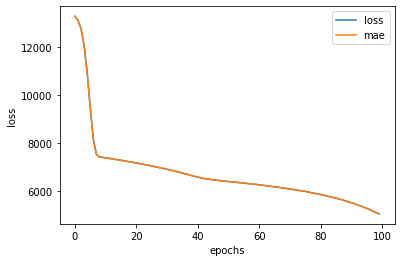

In [ ]:
# Vẽ biểu đồ history (hay còn biết đến là loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

Từ biểu đồ này, có vẻ như loss của mô hình (và MAE) vẫn đang giảm (trong trường hợp này, MAE và loss là như nhau, do đó các đường trong biểu đồ trùng lặp với nhau).

Điều này cho chúng ta biết loss có thể giảm xuống nếu chúng ta cố gắng huấn luyện nó lâu hơn.

> 🤔 **Câu hỏi:** Nên huấn luyện trong bao lâu?

> Điều này phụ thuộc vào bài toán chúng ta bạn đang xử lý. Đôi khi việc huấn luyện sẽ không mất nhiều thời gian, có lúc lại lâu hơn dự kiến. Một phương pháp phổ biến là huấn luyện mô hình trong thời gian rất dài (ví dụ: 1000 epoch), nhưng thiết lập nó bằng [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) để nó tự động dừng khi ngừng cải thiện. Chúng ta sẽ tìm hiểu điều này trong mô-đun khác.

Hãy huấn luyện mô hình tương tự như trên trong thời gian dài hơn một chút. Chúng ta có thể làm điều này nhưng phải gọi lại fit.

In [ ]:
# Thử huấn luyện lâu hơn (hơn 100 epoch)
history_2 = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

Việc huấn luyện thêm diễn ra thế nào?

In [ ]:
# Đánh giá mô hình đã huấn luyện cho tổng cộng 200 epoch
insurance_model_2_loss, insurance_model_2_mae = insurance_model_2.evaluate(X_test, y_test)
insurance_model_2_loss, insurance_model_2_mae

9/9 [==============================] - 0s 1ms/step - loss: 3494.7285 - mae: 3494.7285


(3494.728515625, 3494.728515625)

Sau khi huấn luyện thêm 100 epoch, chúng ta thấy lỗi giảm khoảng 10%.

Kết quả trực quan ra sao?

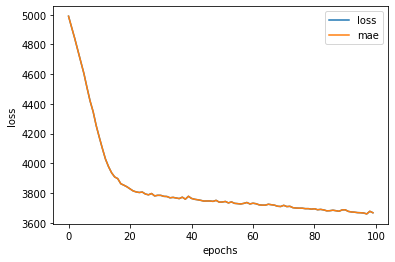

In [ ]:
# Vẽ biểu đồ mô hình đã huấn luyện cho tổng cộng 200 epoch loss curve
pd.DataFrame(history_2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: lưu ý: epoch sẽ chỉ hiển thị 100 vì chúng ta đã ghi đè biến history

## Tiền xử lý dữ liệu (normalization và standardization)

Thường khi làm việc với mạng nơ-ron, cần đảm bảo tất cả dữ liệu chúng ta truyền cho chúng nằm trong phạm vi từ 0 đến 1.

Phương pháp này được gọi là **normalization** (co giãn tất cả các giá trị từ phạm vi ban đầu của chúng, ví dụ: từ 0 đến 100.000 thành từ 0 đến 1).

Một quá trình khác là **standardization**: chuyển đổi tất cả dữ liệu thành phương sai đơn vị và giá trị trung bình bằng 0.

Hai phương pháp này thường là một phần của quy trình tiền xử lý (một loạt các hàm chuẩn bị dữ liệu để sử dụng cho mạng nơ-ron).

Biết được điều này, chúng ta sẽ thực hiện một số bước tiền xử lý trước dữ liệu cho mạng nơ-ron, gồm:
* Chuyển tất cả dữ liệu thành số (mạng nơ-ron không thể xử lý string).
* Đảm bảo dữ liệu ở đúng shape (xác minh shape đầu vào và đầu ra).
* [**Feature scaling (Co giãn đặc trưng)**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Chuẩn hóa dữ liệu (đảm bảo tất cả các giá trị nằm trong khoảng từ 0-1), bằng cách trừ min rồi chia cho max trừ đi min. Đây cũng được gọi là min-max scaling.
    * Chuẩn tắc hóa (đảm bảo tất cả các giá trị có giá trị trung bình là 0 và phương sai là 1). Điều này được thực hiện bằng cách lấy đặc trưng mục tiêu trừ đi giá trị trung bình rồi chia nó cho độ lệch chuẩn.
    * Chúng ta nên dùng loại nào?
      * **Với mạng nơ-ron, chúng ta thường có xu hướng chuẩn hóa** vì chúng ưu tiên các giá trị từ 0 đến 1 (sẽ thấy điều này đặc biệt với xử lý hình ảnh), tuy nhiên, chúng ta thường thấy mạng nơ-ron có thể hoạt động khá tốt với co giãn đặc trưng tối thiểu.

> 📖 **Tài liệu:** Để tìm hiểu thêm về tiền xử lý dữ liệu, hãy đọc các tài liệu sau:
* [Tài liệu về preprocessing data của Scikit-Learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data).
* [Scale, Standardize hay Normalize với Scikit-Learn của Jeff Hale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).

Chúng ta đã chuyển dữ liệu thành số bằng `get_dummies()`, hãy xem làm cách nào để chuẩn hóa dữ liệu đó.

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Đọc tập dữ liệu insurance
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [83]:
# Kiểm tra dữ liệu
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Như trước, chúng ta cần chuyển đổi các cột không phải dạng số thành số; lần này chúng ta sẽ chuẩn hóa cột số với các phạm vi khác nhau (để đảm bảo chúng đều nằm trong khoảng từ 0 đến 1).

Để thực hiện, chúng ta sẽ dùng một số class từ Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - xây dựng một hàm tiền xử lý dữ liệu nhiều bước cho các phép biến đổi sau:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - đảm bảo tất cả các cột số đều được chuẩn hóa (từ 0 đến 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - mã hóa one-hot cho các cột không phải dạng số.

Hãy xem chúng hoạt động thế nào.

In [88]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Tạo column transformer (điều này sẽ giúp chuẩn hóa/tiền xử lý dữ liệu)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # nhận tất cả các giá trị từ 0 đến 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Tạo X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Xây dựng các tập huấn luyện và kiểm tra (sử dụng random state để đảm bảo phân chia như trước)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khớp column transformer với dữ liệu huấn luyện (thực hiện như vậy trên dữ liệu kiểm tra sẽ làm rò rỉ dữ liệu)
ct.fit(X_train)

# Biến đổi dữ liệu huấn luyện và kiểm tra với chuẩn hóa (MinMaxScalar) và mã hóa one-hot (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Chúng ta đã chuẩn hóa nó và mã hóa one-hot, dữ liệu bây giờ trông như thế nào?

In [89]:
# Ví dụ về dữ liệu không mã hóa one-hot và không chuẩn hóa
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [90]:
# Ví dụ về dữ liệu mã hóa one-hot và chuẩn hóa
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

Vậy còn shape?

In [91]:
# Lưu ý rằng shape được mã hóa one-hot/chuẩn hóa lớn sẽ hơn vì có thêm cột
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Dữ liệu đã được chuẩn hóa và ở dạng số, hãy lập mô hình.

Chúng ta sẽ sử dụng mô hình tương tự như `insurance_model_2`.

In [97]:
# Thiết lập random seed
tf.random.set_seed(42)

# Xây dựng mô hình (3 layer, 100, 10, 1 đơn vị)
insurance_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Biên dịch mô hình
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Khớp mô hình cho 200 epoch (tương tự insurance_model_2)
insurance_model_3.fit(X_train_normal, y_train, epochs=200, verbose=0)

Hãy đánh giá mô hình trên dữ liệu kiểm tra đã chuẩn hóa.

In [98]:
# Đánh giá mô hình thứ ba
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 3169.1362 - mae: 3169.1362


Cuối cùng, hãy so sánh kết quả từ `insurance_model_2` (được huấn luyện trên dữ liệu không chuẩn hóa) và `insurance_model_3` (được huấn luyện trên dữ liệu chuẩn hóa).

In [94]:
# Compare modelling results from non-normalized data and normalized data
insurance_model_2_mae, insurance_model_3_mae

NameError: name 'insurance_model_2_mae' is not defined

Từ đó, có thể thấy với cùng một mô hình, việc chuẩn hóa dữ liệu dẫn sẽ dẫn đến lỗi ít hơn 10% so với không chuẩn hóa dữ liệu.

Đây là **một trong những lợi ích chính của chuẩn hóa: thời gian hội tụ nhanh hơn** (một cách nói hoa mỹ, mô hình nhanh đạt được kết quả tốt hơn).

`insurance_model_2` cuối cùng có thể đã đạt được kết quả tương tự như `insurance_model_3` nếu chúng ta huấn luyện lâu hơn.

Ngoài ra, kết quả có thể thay đổi nếu chúng ta thay đổi kiến trúc của mô hình, ví dụ: nhiều đơn vị ẩn hơn ở mỗi layer hoặc nhiều layer hơn.

Nhưng vì mục tiêu chính của chúng ta là giảm thời gian giữa các thử nghiệm, nên bất kỳ điều gì giúp chúng ta sớm đạt được kết quả tốt hơn đều là lợi thế.

## 🛠 Bài tập thực hành
> **Lưu ý:** Các bạn cần làm phần bài tập này để chuẩn bị cho phiên review lab.

Chúng ta đã nhanh chóng bao quát toàn bộ kiến thức.

Giờ là lúc để **thử nghiệm** một vài thứ và bắt đầu vận dụng kiến thức mà các bạn đã học.

Tôi nhấn mạnh việc **thử nghiệm** vì điều đó rất quan trọng. Hãy thử một vài thao tác, chạy code và xem điều gì sẽ xảy ra.

1. Tạo tập dữ liệu hồi quy của riêng bạn (hoặc làm cho tập dữ liệu chúng ta đã tạo trong "Tạo dữ liệu để xem và điều chỉnh" lớn hơn) và xây dựng mô hình phù hợp với nó.
2. Hãy thử xây dựng một mạng nơ-ron với 4 Dense layer và điều chỉnh nó với tập dữ liệu hồi quy, nó thực hiện thế nào?
3. Hãy thử và cải thiện kết quả chúng ta nhận được trên tập dữ liệu insurance, hãy thử một số thứ:
  * Xây dựng mô hình lớn hơn (làm thế nào để mô hình có 4 dense layer hoạt động?).
  * Tăng số lượng đơn vị ở mỗi layer.
  * Tra cứu tài liệu về [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) và tìm xem tham số đầu tiên là gì, điều gì sẽ xảy ra nếu bạn tăng nó lên 10 lần?
  * Điều gì xảy ra nếu bạn huấn luyện lâu hơn (giả sử 300 epoch thay vì 200)?
4. Import [tập dữ liệu Boston pricing](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing/load_data) từ TensorFlow [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) và mô hình hóa nó.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
#Tao mau
X = tf.range(50)[:, tf.newaxis]
X = tf.random.shuffle(X)
y = X+11
#tao mo hinh

model1 = tf.keras.Sequential([tf.keras.layers.Dense(100),
                              tf.keras.layers.Dense(10),
                              tf.keras.layers.Dense(1)])
model1.compile(loss = tf.keras.losses.mae,optimizer=tf.keras.optimizers.Adam(),metrics=['mae'])
model1 = model1.fit(X,y,epochs = 250, verbose=0)
print(pd.DataFrame(model_1.history).min())
pd.DataFrame(model_1.history).plot()

In [ ]:
#Thu mo hinh
y_preds = model1.predict(X[-15:])
plt.scatter(X,y)
plt.scatter(X[-15:],y_preds)

loss    0.028086
mae     0.028086
dtype: float64


<Axes: >

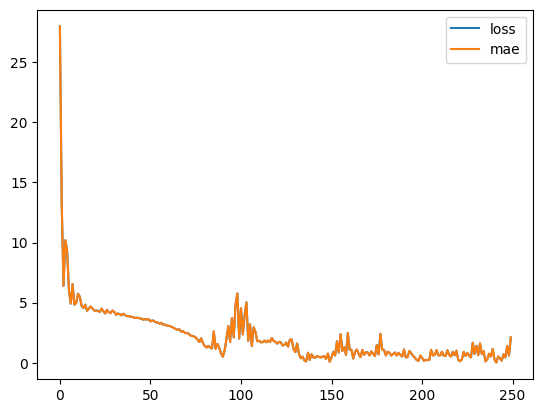

In [81]:
#2.Thu tao 4 layes
import tensorflow as tf
model_2 = tf.keras.Sequential([tf.keras.layers.Dense(200),
                               tf.keras.layers.Dense(100),
                               tf.keras.layers.Dense(10),
                               tf.keras.layers.Dense(1)])
model_2.compile(loss = 'mae',optimizer = 'adam',metrics = 'mae')
model_2 = model_2.fit(X,y,epochs = 250, verbose=0)
print(pd.DataFrame(model_2.history).min())
######### Mô Hình càng sâu thì thời gian sẽ lâu hơn nhưng sẽ có kêt quả tốt hơn.
pd.DataFrame(model_2.history).plot()

9/9 [==============================] - 0s 4ms/step - loss: 3160.9163 - mae: 3160.9163


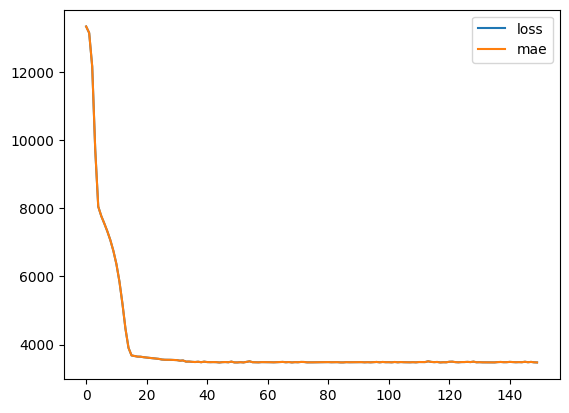

In [114]:
##3.Hãy thử và cải thiện kết quả
import tensorflow as tf
model_3 = tf.keras.Sequential([tf.keras.layers.Dense(200),
                               tf.keras.layers.Dense(100),
                               tf.keras.layers.Dense(10),
                               tf.keras.layers.Dense(1)])
model_3.compile(loss = 'mae',optimizer = 'adam',metrics = 'mae')
H = model_3.fit(X_train_normal, y_train, epochs=150, verbose=0)
pd.DataFrame(H.history).plot()  # tăng epochs lên 300 chỉ làm mô hình chạy lâu hơn, hàm los thay đổi không đáng kể
a,b = model_3.evaluate(X_test_normal, y_test)
######## Mô hình đã cải thiện hơn từ ~3170 xuống còn ~3150, nhưng thời gian lâu hơn

## 📖 Tài liệu đọc thêm

Nếu bạn đang tìm kiếm thêm tài liệu liên quan đến notebok này, hãy xem:

* Video [MIT introduction deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) - cung cấp cái nhìn tổng quan về tất cả các code mà chúng ta đang chạy.
* Dành 1 giờ đọc [Chapter 1 của Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) (Michael Nielson) - ví dụ kiến thức thực tế và chuyên sâu về mạng nơ-ron.

Để luyện tập lập mô hình hồi quy với TensorFlow, tôi khuyến khích các bạn xem qua [tập hợp các tập dữ liệu của Lion Bridge](https://lionbridge.ai/datasets/) hoặc [các tạp dữ liệu của Kaggle](https://www.kaggle.com/data), sau đó tìm tập dữ liệu hồi quy mà bạn quan tâm và thử lập mô hình.